In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-email-classification/email.csv


In [2]:
import numpy as np
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/kaggle/input/spam-email-classification/email.csv')
print(df.isna().sum())
df.head()

Category    0
Message     0
dtype: int64


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df["label"] = df["Category"].replace(["ham", "spam"], [0,1])
df.drop(5572, inplace = True)
df["label"] = df["label"].astype(int)
len(df)


5572

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stemmer = PorterStemmer()
corpus =[]
stopwords_set = set(stopwords.words('english'))
for i in range (len(df)):
    text = df["Message"].iloc[i].lower()
    text = text.translate(str.maketrans('','', string.punctuation)).split()
    text = [stemmer.stem(word) for word in text if word not in stopwords_set]
    text = ' '.join(text)
    corpus.append(text)

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus).toarray()
y = df.label

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
print(X_train.shape)
print(y_train.shape)

(4179, 8094)
(4179,)


In [8]:
#Using PassiveAggressiveClassifier model
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report
pac = PassiveAggressiveClassifier(max_iter=1000, random_state=43)

pac.fit(X_train, y_train)

y_pred = pac.predict(X_test)

Accuracy: 0.9856424982053122
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1208
           1       0.98      0.91      0.94       185

    accuracy                           0.99      1393
   macro avg       0.98      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393

AUC: 0.9945722212278504


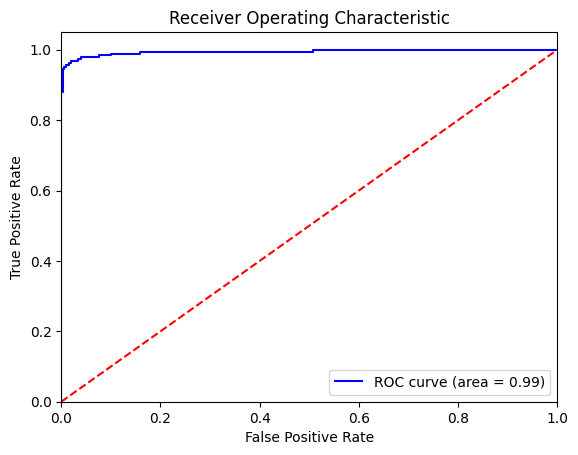

In [9]:
import matplotlib.pyplot as plt

# Reporting Classification Stats
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score, roc_curve

y_scores = pac.decision_function(X_test)

# Find ROC and AUC
roc_auc = roc_auc_score(y_test, y_scores)
print(f'AUC: {roc_auc}')

# Plotting ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [10]:
#Using K-Folds CrossValidation to check overfitting
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pac, X, y, cv=kf, scoring='f1')

print("F1 Score of each folds:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

F1 Score of each folds: [0.94444444 0.93478261 0.93515358 0.89298893 0.92041522]
Mean F1 Score: 0.9255569583121277
Standard Deviation: 0.018005881663205138
